# Ben Kim: GPR notebook (Introductory)

Getting a feel for GPR and its performance based on sample size.

 https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html

In [1]:
# Set up
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel
from sklearn.metrics import mean_absolute_error
import random
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import requests
import time

## latin hypercube (LHS) data

In [2]:
LHS_url = 'https://raw.githubusercontent.com/benkim1226/footballdata/master/LHS_complete.csv'
LHS_data = pd.read_csv(LHS_url, index_col = 0)
LHS_data = LHS_data.reset_index()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaled_LHS = scaler.fit_transform(LHS_data)
scaled_LHS = pd.DataFrame(scaled_LHS)

In [3]:
X = scaled_LHS.loc[:,0:13]
y = LHS_data['simulation_values']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
constant = 1 # changing this only impacts hyperparameters
length_scale_array = 1.0
kernel = constant * RBF(length_scale = length_scale_array, length_scale_bounds=(1e-2, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)
gpr.fit(X_train, y_train)
gpr.kernel_ # lets us see the tuned parameters

5.76**2 * RBF(length_scale=16)

In [5]:
print('Performance Summary:')
print("GPR.score(): " + str(gpr.score(X, y)))
print("R-squared: "+str(r2_score(y_test, gpr.predict(X_test))))
print("MSE: "+ str(mean_squared_error(y_test, gpr.predict(X_test))))
print("MAE test:" + str(mean_absolute_error(y_test, gpr.predict(X_test))))

Performance Summary:
GPR.score(): 0.9999845021895457
R-squared: 0.9999239762652374
MSE: 0.026683096341675573
MAE test:0.12528625235466792


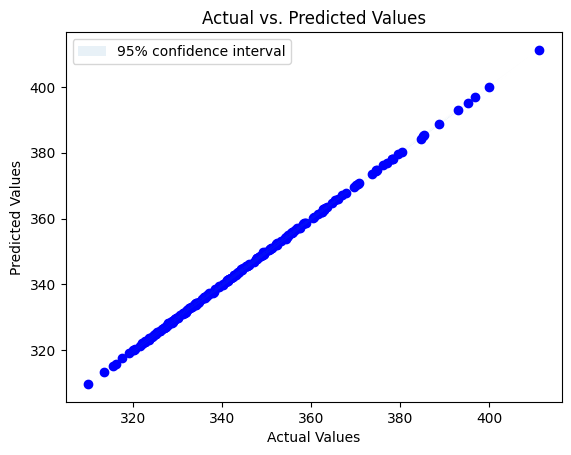

In [6]:
mean_prediction, std_prediction = gpr.predict(X_test, return_std=True)

plt.scatter(y_test, mean_prediction, color='blue')

plt.fill_between(
    y_test,
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.1,
    label=r"95% confidence interval",
)

#plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

Okay, the GPR looks pretty good.

# Varying Sample Size (S)

Above we worked with a dataset of n = 1000. What happens with values of (0,1000)?


In [7]:
sample_sizes = list(np.around((np.logspace(1, 2.7, 15)),0)) # USE LOGISTICAL SAMPLE SIZES (efficiency)
sample_sizes = [int(x) for x in sample_sizes]

In [8]:
MSE_train = []
MSE_test = []

R2_train = []
R2_test = []

MAE_train = []
MAE_test = []
MAE_test_stds = []

def sample_test_func():
  for s in sample_sizes:

    indexes = random.sample(range(0, 1000), s)

    sample_data = scaled_LHS.loc[indexes]
    sample_y = LHS_data['simulation_values'].loc[indexes]

    X = sample_data.loc[:,0:13]
    y = sample_y

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    constant = 1
    kernel = constant * RBF(length_scale=1, length_scale_bounds=(1e-3, 1e3))

    gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9, normalize_y = True)

    gpr.fit(X_train, y_train)

    y_train_pred = gpr.predict(X_train)
    y_test_pred = gpr.predict(X_test)

    MAE_train.append(mean_absolute_error(y_train, y_train_pred))
    MAE_test.append(mean_absolute_error(y_test, y_test_pred))

    MSE_train.append(mean_squared_error(y_train, y_train_pred))
    MSE_test.append(mean_squared_error(y_test, y_test_pred))


    R2_train.append(r2_score(y_train, y_train_pred))
    R2_test.append(r2_score(y_test, y_test_pred))

  print("Average MSE: "+str(np.mean(MSE_test)))
  print("Average MAE: "+str(np.mean(MAE_test)))

In [9]:
sample_test_func()

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Average MSE: 54.690430018139324
Average MAE: 4.4566172243933595


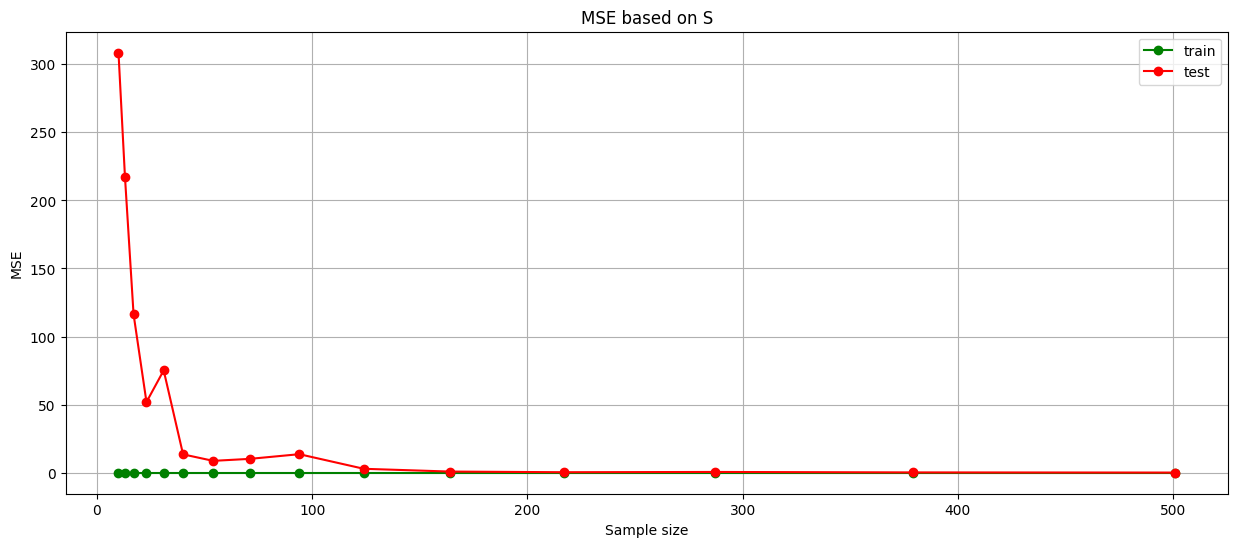

In [10]:
# Plotting the MSE of the testng and training sets based off of sample size

plt.figure(figsize=(15,6))
plt.plot(sample_sizes, MSE_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, MSE_test, 'o-', color='red', label='test')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('MSE')
plt.title('MSE based on S')
plt.show()

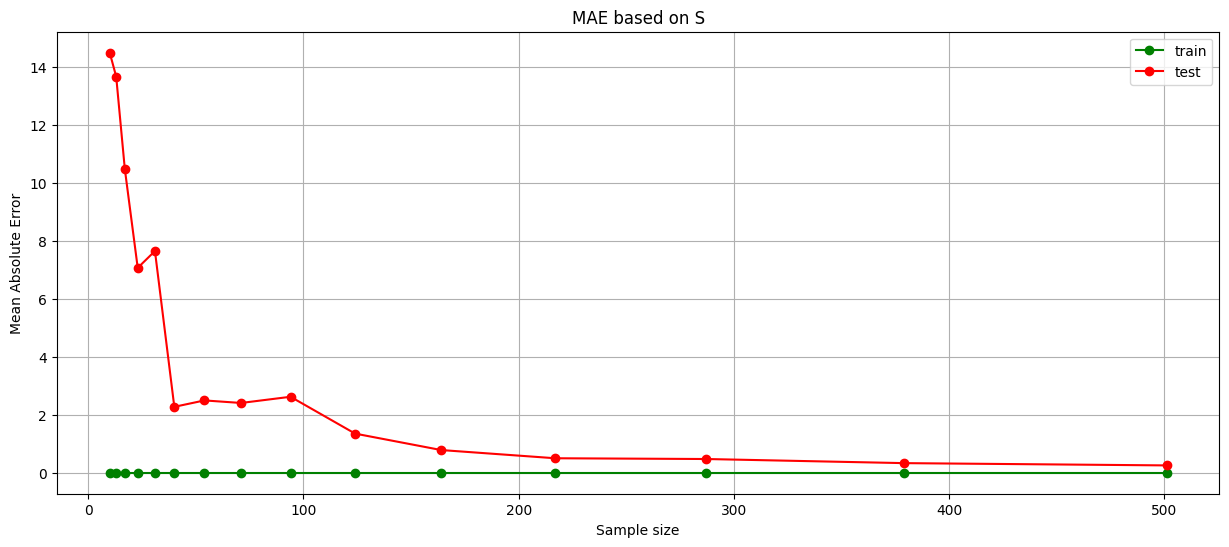

In [11]:
# Plotting the MAE of the testng and training sets based off of sample size

plt.figure(figsize=(15,6))
plt.plot(sample_sizes, MAE_train, 'o-', color='green', label='train')
plt.plot(sample_sizes, MAE_test, 'o-', color='red', label='test')

plt.legend()
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('Mean Absolute Error')
plt.title('MAE based on S')
plt.show()

Based off these three
 graphs, it appears that the optimal sample size is around 200 with 14 variables. I wonder if reducing the number of variables would require more or less samples.